# Demographics of participants

### Data to report outliers and overall dropout rate are PARTICIPANTS
### Data for the detailed analysis are VALID_PARTICIPANTS
##### (see cleaning_sampling.ipynb for details)

In [26]:
from configparser import ConfigParser
from sqlalchemy import create_engine
import pandas as pd
from ua_parser import user_agent_parser
from geolite2 import geolite2
import geopandas as gpd
import pycountry
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
sns.set_palette('autumn')

def read_db_config(filename='config-dump.ini', section='mysql'):
    """ Read database configuration file and return a dictionary object
    :param filename: name of the configuration file
    :param section: section of database configuration
    :return: a dictionary of database parameters
    """
    # create parser and read ini configuration file
    parser = ConfigParser()
    parser.read(filename)
 
    # get section, default to mysql
    db = {}
    if parser.has_section(section):
        items = parser.items(section)
        for item in items:
            db[item[0]] = item[1]
    else:
        raise Exception('{0} not found in the {1} file'.format(section, filename))
 
    return db

dbconfig = read_db_config()
CONN = 'mysql+mysqlconnector://'+dbconfig['user']+':'+dbconfig['pwd']+'@'+dbconfig['host']+':'+dbconfig['port'] + '/'+dbconfig['dbname']
engine = create_engine(CONN)

# Outlier report (using PARTICIPANTS table)

In [27]:
# Load data of all participants 
P_QUERY = "SELECT * FROM PARTICIPANTS" 
p_all = pd.read_sql_query(P_QUERY, engine)
p_all.fillna(0, inplace=True)

In [28]:
numrows = len(p_all)

print(f"Number of raw records in PARTICIPANTS: {len(p_all)}")

mask = (p_all.WPM <= 0) | (p_all.WPM >= 200)
print(f"WPM outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.ERROR_RATE < 0) | (p_all.ERROR_RATE >= 25)
print(f"ERROR_RATE outliers: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.IP_ADDRESS == 0)
print(f"IP_ADDRESS zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.FINGERS == 'undefined;undefined') | (p_all.FINGERS == 'false') | (p_all.FINGERS == 'other')
print(f"FINGERS undefined: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 0) 
print(f"DEVICE zero: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )

mask = (p_all.DEVICE == 'desktop') 
print(f"DEVICE = desktop: {len(p_all[mask])} ({len(p_all[mask])/numrows:2.2%})" )


Number of raw records in PARTICIPANTS: 87258
WPM outliers: 72231 (82.78%)
ERROR_RATE outliers: 470 (0.54%)
IP_ADDRESS zero: 2908 (3.33%)
FINGERS undefined: 83 (0.10%)
DEVICE zero: 3404 (3.90%)
DEVICE = desktop: 3305 (3.79%)


# Demographic analysis (using VALID_PARTICIPANTS table)

In [29]:
# Load data of valid participants 
P_QUERY = "SELECT * FROM VALID_PARTICIPANTS" 
participants = pd.read_sql_query(P_QUERY, engine)
participants.fillna(0, inplace=True)
participants.rename(columns={'BROWSER': 'UA'}, inplace=True)

## Data cleaning and feature parsing

In [30]:
def parse_fingers_usage():
    # Parsing reported hands and fingers
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;thumbs' if x =='1 hand thumb' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'right_hand;index_fingers' if x =='1 hand pointer' else x)
    participants['FINGERS'] = participants.FINGERS.apply(lambda x: 'both_hands;thumbs' if x =='2 hands thumbs' else x)
    participants[['HAND','FINGER','NUM_FINGERS']] = participants['FINGERS'].str.split(';',expand=True)
    participants.fillna('0', inplace=True)

    # If number of fingers reported
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: str(x).strip())
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'all', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'10', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 10 if bool(re.search(r'ten', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'8', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 8 if bool(re.search(r'eight', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'5', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 5 if bool(re.search(r'five', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'4', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'Four', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'2 on both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 4 if bool(re.search(r'(thumbs|fingers).*(thumbs|fingers)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'3', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 3 if bool(re.search(r'three', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'2', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'two', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'both', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|index).*(index|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(thumb|middle).*(middle|thumb)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(index|middle).*(middle|index)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(middle|ring).*(ring|middle)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'(pinky|middle).*(middle|pinky)', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 2 if bool(re.search(r'thumbs', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if bool(re.search(r'one', str(x), re.IGNORECASE)) else x) 
    participants['NUM_FINGERS'] = participants.NUM_FINGERS.apply(lambda x: 1 if str(x) == '1' else x) 
    
    # If no number of fingers reported, calculate it from selected HAND and FINGERS options
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'both_hands'), 'NUM_FINGERS'] = 2
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'left_hand'), 'NUM_FINGERS'] = 1
    participants.loc[(participants.NUM_FINGERS == '0') & (participants.HAND == 'right_hand'), 'NUM_FINGERS'] = 1



def parse_advanced_input():
    # Parsing reported features 
    participants['REP_F_SWIPE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'swipe', x))))
    participants['REP_F_PREDICTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'prediction', x))))
    participants['REP_F_AUTOCORRECTION'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'autocorrection', x))))
    participants['REP_F_OTHER'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'other', x))))
    participants['REP_F_NO'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'"no"', x))))
    participants['REP_F_NOTSURE'] = participants.USING_FEATURES.apply(lambda x: int(bool(re.search(r'notsure', x))))
    

def parse_keyboard_app():
    # Parsing reported keyboard app
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: x.strip())
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Kika' if bool(re.search(r'kik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Emoji' if bool(re.search(r'Emjoi', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Cheetah' if bool(re.search(r'Cheet', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Fleksy' if bool(re.search(r'Flesky', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Minuum' if bool(re.search(r'Minimum', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Blackberry' if bool(re.search(r'Blackberry', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Grammarly' if bool(re.search(r'Gramme', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Ridmik' if bool(re.search(r'Ridmik', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Facemoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'FancyKey' if bool(re.search(r'Fanc', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Facemoji' if bool(re.search(r'Face emoji', x, re.IGNORECASE)) else x) 
    participants['USING_APP'] = participants.USING_APP.apply(lambda x: 'Go' if bool(re.search(r'Go keyb', x, re.IGNORECASE)) else x) 

def parse_user_agent():
    ### Parsing User Agent string
    participants['BROWSER'] = participants.UA.apply(lambda x:  user_agent_parser.ParseUserAgent(x)['family'])
    participants['OS'] = participants.UA.apply(lambda x:  user_agent_parser.ParseOS(x)['family'])
    participants['D_FAMILY'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['family'])
    participants['D_BRAND'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['brand'])
    participants['D_MODEL'] = participants.UA.apply(lambda x:  user_agent_parser.ParseDevice(x)['model'])

In [31]:
parse_fingers_usage()
parse_advanced_input()
parse_keyboard_app()
parse_user_agent()

# Time spent typing - convert to numeric 
participants['TIME_SPENT_TYPING'] = pd.to_numeric(participants.TIME_SPENT_TYPING, errors='coerce')

participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 

# Type Finnish == '' in case of native==Finnish, set it to 'native'
participants['TYPE_TEST_LANG'] = participants.TYPE_TEST_LANG.apply(lambda x: 'native' if x== '' else x)

mask = (participants.WPM <= 0) | (participants.WPM >= 200)
print("Removed as WPM outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.ERROR_RATE < 0) | (participants.ERROR_RATE >= 25)
print("Removed as ERROR_RATE outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.IP_ADDRESS == 0)
print("Removed as IP_ADDRESS outliers: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.FINGERS == 'undefined;undefined') | (participants.FINGERS == 'false') | (participants.FINGERS == 'other')
print("Removed as FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 0) 
print("Removed as DEVICE zero: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.DEVICE == 'desktop') 
print("Removed as DEVICE = desktop: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.HAND == 'undefined') | (participants.FINGER == 'undefined') | (participants.FINGER == 'false')
print("Removed as HAND / FINGERS undefined: ", len(participants[mask]))
participants = participants[~mask]

mask = (participants.TIME_SPENT_TYPING > 24) | (participants.TIME_SPENT_TYPING < 0)
print("Removed as TIME_SPENT_TYPING invalid: ", len(participants[mask]))
participants = participants[~mask]

Removed as WPM outliers:  0
Removed as ERROR_RATE outliers:  0
Removed as IP_ADDRESS outliers:  0
Removed as FINGERS undefined:  29
Removed as DEVICE zero:  0
Removed as DEVICE = desktop:  0
Removed as HAND / FINGERS undefined:  13
Removed as TIME_SPENT_TYPING invalid:  1


## Preprocessed data

In [32]:
cols_demo = ['AGE', 'HAS_TAKEN_TYPING_COURSE', 'TIME_SPENT_TYPING']
participants[cols_demo].describe().applymap("{:.3f}".format) #.to_csv('p_describe.csv')

AGE HAS_TAKEN_TYPING_COURSE TIME_SPENT_TYPING
count  8413.000                8413.000          8385.000
mean     23.795                   0.275             6.749
std       7.629                   0.447             6.343
min       7.000                   0.000             0.000
25%      19.000                   0.000             2.000
50%      22.000                   0.000             4.000
75%      28.000                   1.000            10.000
max      47.000                   1.000            24.000

In [33]:
cols_perf = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_KSPC']
participants[cols_perf].describe().applymap("{:.3f}".format)

WPM ERROR_RATE     P_KPD     P_IKI     P_BSP    P_ECPC    P_KSPC
count  8413.000   8413.000  8413.000  8413.000  8413.000  8413.000  8413.000
mean     35.694      2.324    19.856   108.320     1.858     0.048     1.183
std      12.758      2.017    21.814    50.496     1.918     0.050     0.179
min       0.216      0.000    -2.761    16.032     0.000     0.000     0.301
25%      26.692      0.979    12.297    72.769     0.200     0.005     1.072
50%      33.986      1.740    16.952    97.423     1.400     0.036     1.148
75%      43.082      3.074    20.843   131.824     2.800     0.073     1.276
max      97.419     22.822   618.656   454.441    17.133     0.422     2.143

In [34]:
participants.tail(5)

PARTICIPANT_ID       IP_ADDRESS  \
8451           87227   157.48.184.115   
8452           87230    197.210.54.65   
8453           87233    98.222.42.158   
8454           87240  174.106.168.123   
8455           87241   157.50.253.143   

                                                     UA  \
8451  Mozilla/5.0 (Linux; Android 7.1.1; SM-T350 Bui...   
8452  Mozilla/5.0 (Linux; Android 8.1.0; itel S13 Bu...   
8453  Mozilla/5.0 (iPhone; CPU iPhone OS 11_3 like M...   
8454  Mozilla/5.0 (iPhone; CPU iPhone OS 12_0_1 like...   
8455  Mozilla/5.0 (Linux; Android 6.0.1; SM-G600FY B...   

                BROWSER_LANGUAGE  DEVICE  SCREEN_W  SCREEN_H  AGE  GENDER  \
8451     en-US,en;q=0.9,te;q=0.8  mobile       586       781   15    male   
8452  en-GB,en-US;q=0.9,en;q=0.8  mobile       320       640   31  female   
8453                       en-us  mobile       414       736   27  female   
8454                       en-us  mobile       414       736   21  female   
8455     en-US,en;q=0.9,hi;q=0.8  mobile       360       640   25    male   

      HAS_TAKEN_TYPING_COURSE        ...         REP_F_AUTOCORRECTION  \
8451                        0        ...                            0   
8452                        0        ...                            1   
8453                        1        ...                            0   
8454                        0        ...                            0   
8455                        1        ...                            0   

      REP_F_OTHER  REP_F_NO REP_F_NOTSURE        BROWSER       OS  \
8451            0         1             0  Chrome Mobile  Android   
8452            0         1             0  Chrome Mobile  Android   
8453            0         1             0  Mobile Safari      iOS   
8454            0         1             0  Mobile Safari      iOS   
8455            0         0             1  Chrome Mobile  Android   

               D_FAMILY          D_BRAND    D_MODEL        HAND_FINGER  
8451    Samsung SM-T350          Samsung    SM-T350  both_hands;thumbs  
8452           itel S13  Generic_Android   itel S13  both_hands;thumbs  
8453             iPhone            Apple     iPhone  both_hands;thumbs  
8454             iPhone            Apple     iPhone  both_hands;thumbs  
8455  Samsung SM-G600FY          Samsung  SM-G600FY  both_hands;thumbs  

[5 rows x 41 columns]

## Mapping of reported native languages and detected countries

In [35]:
def get_country_iso(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['iso_code'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

geo = geolite2.reader()

unique_ips = participants.IP_ADDRESS.unique()
unique_ips = pd.Series(unique_ips, index = unique_ips)
participants['DET_COUNTRY'] = participants.IP_ADDRESS.map(unique_ips.apply(get_country_iso))

geolite2.close()

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Number of participants mapped by detected country')

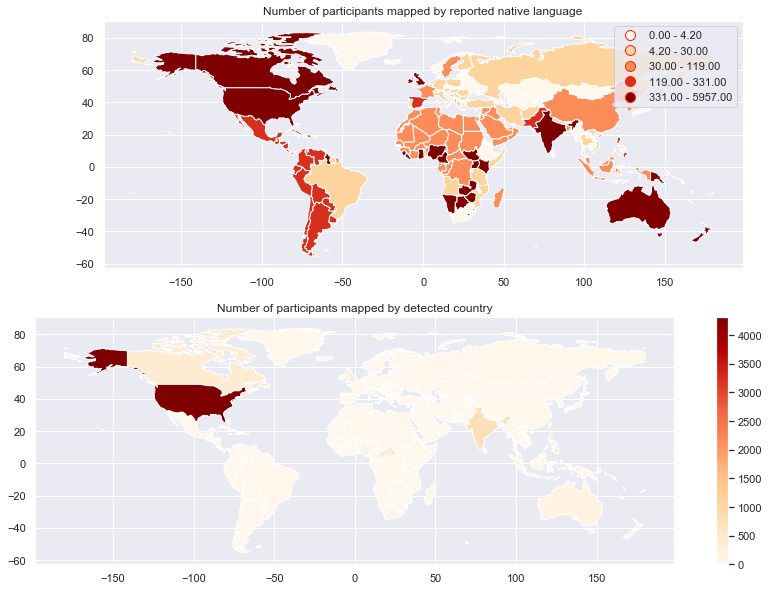

In [36]:
# World map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['iso_a2']=world['iso_a3'].apply(lambda x: x[:2])

# Dataframe for mapping country code and language
# http://download.geonames.org/export/dump/countryInfo.txt
geonames = pd.read_csv('geonames.txt', sep='\t', usecols=['ISO3', 'Country', 'Languages'])
geonames.dropna(inplace=True, axis=0)
geonames['lang'] = geonames['Languages'].apply(lambda x: re.split('[,-]', x)[0])

# Merge two dataframes above by country code
langmap1 = pd.merge(world, geonames[['ISO3', 'lang']], how='inner', left_on=['iso_a3'], right_on=['ISO3']).fillna(0, downcast='infer')
# Count and map participants by NATIVE_LANGUAGE
lang_native = participants.NATIVE_LANGUAGE.value_counts().to_frame()
lang_native.reset_index(inplace=True)
lang_native.rename(columns={'index':'lang', 'NATIVE_LANGUAGE': 'lang_native_cnt'}, inplace=True)
#lang_native['log_lang_native_cnt'] = lang_native.lang_native_cnt.apply(lambda x: np.log(x)) 
langmap1 = pd.merge(langmap1, lang_native, how='left', on='lang')
langmap1.fillna(0, inplace=True, downcast='infer')

# Count and map participants by DET_COUNTRY
det_country = participants.DET_COUNTRY.value_counts().to_frame()
det_country.reset_index(inplace=True)
det_country.rename(columns={'index':'iso_a2', 'DET_COUNTRY': 'det_country_cnt'}, inplace=True)
#det_country['log_det_country_cnt'] = det_country.det_country_cnt.apply(lambda x: np.log(x)) 
langmap2 = pd.merge(world, det_country, how='left', on='iso_a2')
langmap2.fillna(0, inplace=True, downcast='infer')

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
langmap1.plot(column='lang_native_cnt', cmap='OrRd', scheme='quantiles', ax=axs[0], legend = True);
axs[0].set_title('Number of participants mapped by reported native language')
langmap2.plot(column='det_country_cnt', cmap='OrRd',  ax=axs[1], legend = True);
axs[1].set_title('Number of participants mapped by detected country')

## TOP-N aggregates

In [37]:
N = 5

# Countries
country = participants.DET_COUNTRY.value_counts(normalize=True).reset_index()[:N]

# Native NATIVE_LANGUAGE
native = participants.NATIVE_LANGUAGE.value_counts(normalize=True).reset_index()[:N]

# Genders
gender = participants.GENDER.value_counts(normalize=True).reset_index()[:N]

# Finnish typing
type_eng = participants.TYPE_TEST_LANG.value_counts(normalize=True).reset_index()[:N]

demogr_summary = pd.concat([gender, country, native, type_eng], axis=1)
demogr_summary.columns = ['GENDER', 'GENDER %', 'DET_COUNTRY', 'DET_COUNTRY %','NATIVE_LANGUAGE', 'NATIVE_LANGUAGE %', 'TYPE_TEST_LANG', 'TYPE_TEST_LANG %']
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] * 100
demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']] = demogr_summary[['GENDER %','DET_COUNTRY %', 'NATIVE_LANGUAGE %','TYPE_TEST_LANG %']].applymap("{:.2f}".format)
demogr_summary

GENDER GENDER % DET_COUNTRY DET_COUNTRY % NATIVE_LANGUAGE  \
0  female    67.16          US         51.28              en   
1    male    28.52          IN          8.87              es   
2    none     4.33          PH          7.72              tl   
3     NaN      nan          CA          4.72              hi   
4     NaN      nan          GB          3.86              ur   

  NATIVE_LANGUAGE % TYPE_TEST_LANG TYPE_TEST_LANG %  
0             70.81       native          59.09  
1              3.93       always          19.22  
2              3.80      usually          11.36  
3              2.56    sometimes           8.06  
4              2.15       rarely           1.90

In [38]:
N = 5

# Hand
hand = participants.HAND.value_counts(normalize=True).reset_index()[:N]

# Finger
finger = participants.FINGER.value_counts(normalize=True).reset_index()[:N]

# Hand and finger
# participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 
hand_finger = participants.HAND_FINGER.value_counts(normalize=True).reset_index()[:N]

# Layout
layout = participants.LAYOUT.value_counts(normalize=True).reset_index()[:N]

# Keyboard app
using_app = participants.USING_APP.value_counts(normalize=True).reset_index()[:N]

behav_summary = pd.concat([hand, finger, hand_finger, layout, using_app], axis=1)
behav_summary.columns = ['HAND', 'HAND %', 'FINGER', 'FINGER %','HAND_FINGER', 'HAND_FINGER %', 'LAYOUT', 'LAYOUT %', 'USING_APP', 'USING_APP %']
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] * 100
behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']] = behav_summary[['HAND %','FINGER %', 'HAND_FINGER %','LAYOUT %', 'USING_APP %']].applymap("{:.2f}".format)
behav_summary

HAND HAND %          FINGER FINGER %                HAND_FINGER  \
0  both_hands  85.33          thumbs    84.12          both_hands;thumbs   
1  right_hand  13.23  other-nfingers     7.02          right_hand;thumbs   
2   left_hand   1.44   index_fingers     5.67  both_hands;other-nfingers   
3         NaN    nan           other     1.70   both_hands;index_fingers   
4         NaN    nan  middle_fingers     1.49   right_hand;index_fingers   

  HAND_FINGER %  LAYOUT LAYOUT % USING_APP USING_APP %  
0         73.73  qwerty    87.51     false       79.32  
1          9.33  qwertz     5.87   notsure       13.98  
2          6.55   other     3.35    Gboard        2.23  
3          3.17  azerty     3.27  SwiftKey        1.71  
4          2.33     NaN      nan  Touchpal        0.67

In [39]:
N = 10

# Browsers
browser = participants.BROWSER.value_counts(normalize=True).reset_index()[:N]

# OS 
os = participants.OS.value_counts(normalize=True).reset_index()[:N]

# Device family
dfam = participants.D_FAMILY.value_counts(normalize=True).reset_index()[:N]

# Device brand
dbrand = participants.D_BRAND.value_counts(normalize=True).reset_index()[:N]

# Device model
dmodel = participants.D_MODEL.value_counts(normalize=True).reset_index()[:N]

# Screen width
dscrw = participants.SCREEN_W.value_counts(normalize=True).reset_index()[:N]

# Screen height
dscrh = participants.SCREEN_H.value_counts(normalize=True).reset_index()[:N]

devices_summary = pd.concat([browser, os, dfam, dbrand, dmodel, dscrw, dscrh], axis=1)
devices_summary.columns = ['BROWSER', 'BROWSER %','OS', 'OS %','D_FAMILY','D_FAMILY %', 'D_BRAND', 'D_BRAND %','D_MODEL','D_MODEL %', 'SCREEN_W','SCREEN_W %', 'SCREEN_H', 'SCREEN_H %']
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %']] * 100
devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %']] = devices_summary[['BROWSER %', 'OS %','D_FAMILY %', 'D_BRAND %', 'D_MODEL %', 'SCREEN_W %', 'SCREEN_H %']].applymap("{:.2f}".format)
devices_summary

BROWSER BROWSER %             OS   OS %  \
0               Mobile Safari     42.10        Android  50.99   
1               Chrome Mobile     37.26            iOS  48.92   
2                    Facebook      6.42  Windows Phone   0.08   
3            Samsung Internet      5.73            NaN    nan   
4           Chrome Mobile iOS      3.23            NaN    nan   
5       Chrome Mobile WebView      1.41            NaN    nan   
6  Mobile Safari UI/WKWebView      1.20            NaN    nan   
7                      Chrome      0.77            NaN    nan   
8                  UC Browser      0.68            NaN    nan   
9                 Amazon Silk      0.30            NaN    nan   

              D_FAMILY D_FAMILY %          D_BRAND D_BRAND %       D_MODEL  \
0               iPhone      42.47            Apple     48.92        iPhone   
1                 iPad       6.34          Samsung     21.73          iPad   
2  XiaoMi Redmi Note 4       2.72  Generic_Android      8.70  Redmi Note 4   
3     Samsung SM-G950U       0.88           XiaoMi      5.02      SM-G950U   
4     Samsung SM-G960U       0.76               LG      3.53      SM-G960U   
5     Samsung SM-G955U       0.73           Huawei      3.02      SM-G955U   
6     Samsung SM-G950F       0.69             vivo      1.72      SM-G950F   
7                 Z982       0.67         Motorola      1.58          Z982   
8           LM-X210(G)       0.59              ZTE      1.32    LM-X210(G)   
9              LGMP260       0.58          Generic      0.58         MP260   

  D_MODEL %  SCREEN_W SCREEN_W %  SCREEN_H SCREEN_H %  
0     40.02       360      35.41       640      28.92  
1      6.19       375      22.94       667      18.34  
2      2.72       414      16.00       736      15.64  
3      0.88       412       7.77       812       4.58  
4      0.76       320       6.74       768       4.47  
5      0.73      1024       4.68       846       3.66  
6      0.69       768       1.85       568       3.57  
7      0.67       424       0.87       732       3.19  
8      0.59       393       0.87       740       3.05  
9      0.58       600       0.49       720       2.42

## Visualisations

In [ ]:
#cols = ['SCREEN_W', 'SCREEN_H', 'AGE', 'GENDER', 'WPM', 'ERROR_RATE', 'TIME_SPENT_TYPING']
#sns.pairplot(participants[cols], hue="GENDER",  plot_kws={'alpha': 0.2})

In [40]:
# Prepare data for visualisations
typing_features = pd.DataFrame({'REP_FEATURE': ['swipe', 'prediction', 'autocorr.', 'other', 'no', 'not sure'], 
                                'count': [participants.REP_F_SWIPE.value_counts()[1], 
                                          participants.REP_F_PREDICTION.value_counts()[1], 
                                          participants.REP_F_AUTOCORRECTION.value_counts()[1],
                                          participants.REP_F_OTHER.value_counts()[1],
                                          participants.REP_F_NO.value_counts()[1],
                                          participants.REP_F_NOTSURE.value_counts()[1]]})
typing_features.sort_values(by='count', inplace=True, ascending=False)
typing_features['freq'] = typing_features['count']*100 / sum(typing_features['count'])

using_app = participants.USING_APP.value_counts().reset_index()
using_app.rename(columns={'index':'REP_USING_APP', 'USING_APP':'count'}, inplace=True)
using_app['freq'] = using_app['count']*100 / sum(using_app['count'])

# Count number of fingers
fingers = participants.NUM_FINGERS.value_counts().reset_index()
fingers['number'] = pd.to_numeric(fingers['index'], errors='coerce')
fingers.rename(columns={'NUM_FINGERS':'count', 'number': 'REP_NUM_FINGERS'}, inplace=True)
fingers = fingers[['REP_NUM_FINGERS', 'count']]
fingers.dropna(inplace=True)
fingers.sort_values(by='REP_NUM_FINGERS', inplace=True)
fingers.REP_NUM_FINGERS = fingers.REP_NUM_FINGERS.astype(int)
fingers['freq'] = fingers['count']*100 / sum(fingers['count'])


Text(696.8235294117648, 0.5, 'Frequency [%]')

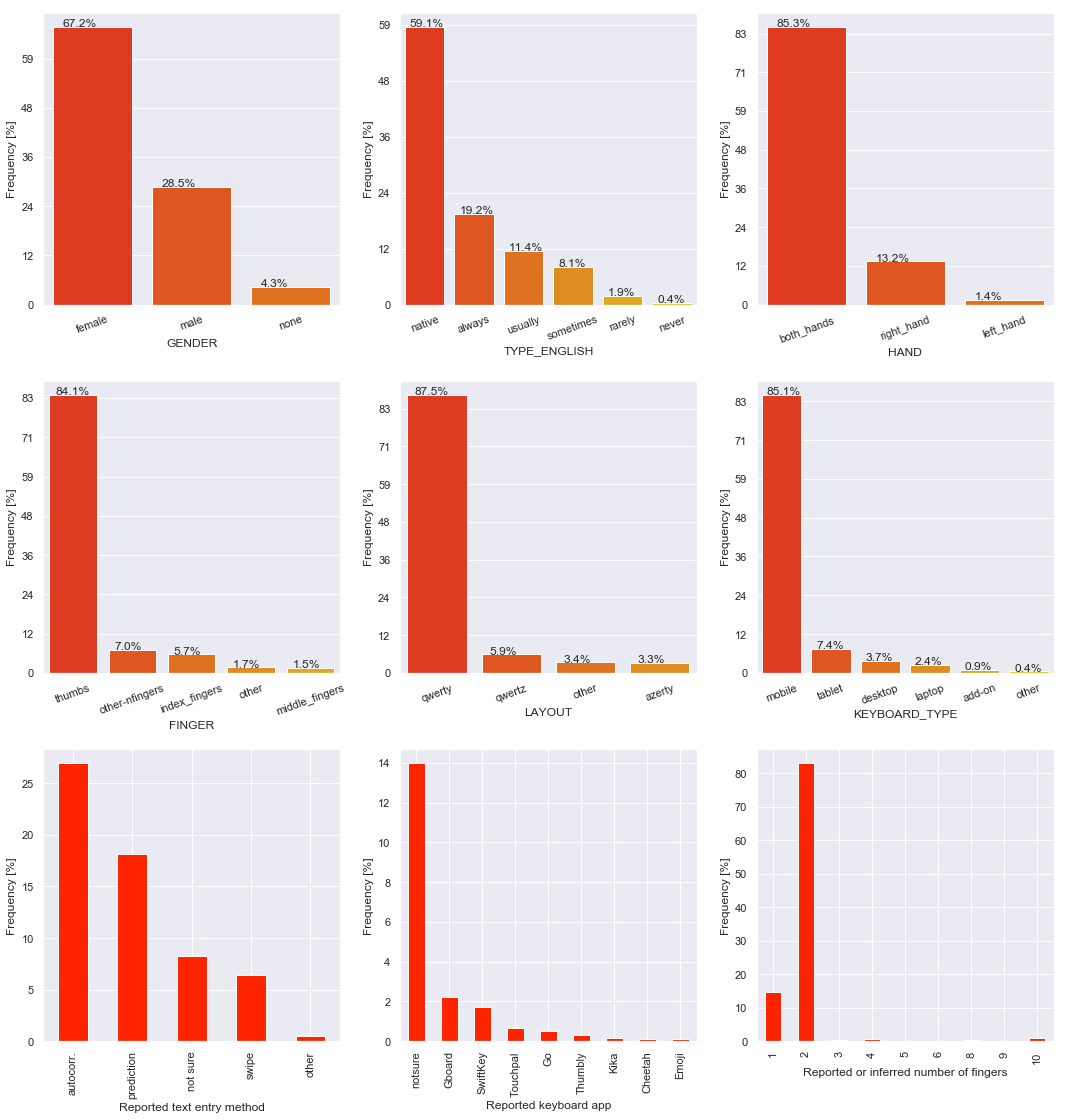

In [44]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

#with plt.xkcd():
total = len(participants)*1.
ROWS = 3
COLS = 3
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15,15))

features = ['GENDER','TYPE_TEST_LANG','HAND',
            'FINGER','LAYOUT','KEYBOARD_TYPE']
for i in range(0,len(features)):
    f = features[i]
    rown = int(i/COLS)
    coln = i%COLS
    if is_numeric_dtype(participants[f]):
        sns.distplot(participants[f], ax=axs[rown,coln])
        axs[rown,coln].set(ylabel="Density")

    if is_string_dtype(participants[f]):
        #sns.barplot(x=participants[f], y=participants[f], data=participants, estimator=lambda x: len(x) / len(df) * 100)
        sns.countplot(participants[f], order = participants[f].value_counts().index, ax=axs[rown,coln])
        #adjust the ticklabel to the desired format, without changing the position of the ticks. 
        axs[rown,coln].set_yticklabels(map('{:.0f}'.format, 100*axs[rown,coln].yaxis.get_majorticklocs()/total))
        axs[rown,coln].set_xticklabels(axs[rown,coln].get_xticklabels(),rotation=20)
        for p in axs[rown,coln].patches:
            axs[rown,coln].annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
        axs[rown,coln].set(ylabel="Frequency [%]")


plt.tight_layout()

last_row_idx = 2
typing_features[typing_features.REP_FEATURE != 'no'].plot("REP_FEATURE", "freq", kind="bar", ax=axs[last_row_idx,0], legend=False)
axs[last_row_idx,0].set_xlabel('Reported text entry method')
axs[last_row_idx,0].set_ylabel('Frequency [%]')

using_app[(using_app.freq > 0.1) & (using_app.REP_USING_APP != 'false')].plot("REP_USING_APP", "freq", kind='bar',  ax=axs[last_row_idx,1], legend=False)
axs[last_row_idx,1].set_xlabel('Reported keyboard app')
axs[last_row_idx,1].set_ylabel('Frequency [%]')

fingers.plot("REP_NUM_FINGERS", "freq", kind="bar", ax=axs[last_row_idx,2], legend=False)
axs[last_row_idx,2].set_xlabel('Reported or inferred number of fingers')
axs[last_row_idx,2].set_ylabel('Frequency [%]')
 

## Distributions

TypeError: distplot() got an unexpected keyword argument 'hue'

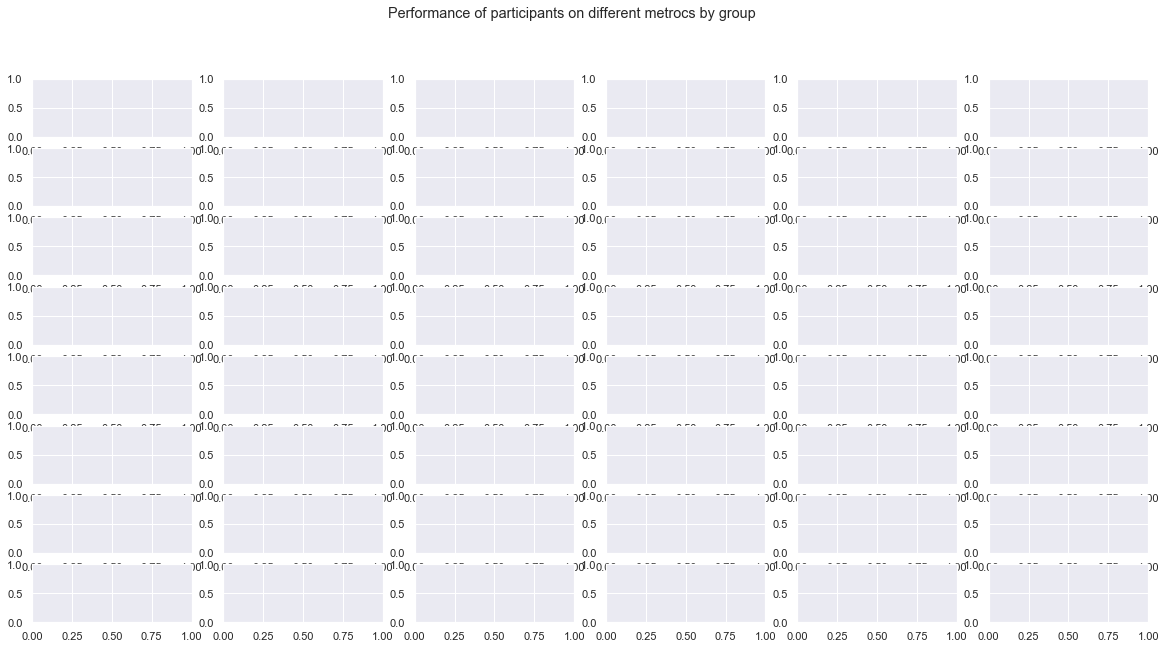

In [67]:
sns.set_palette('RdYlGn')
metrics = ['WPM', 'ERROR_RATE', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN', 'P_KSPC']
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

ROWS = len(metrics)
COLS = len(latents)
fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(20,10))
plt.suptitle('Performance of participants on different metrocs by group')
for i in range(0,len(metrics)): 
    for j in range(0,len(latents)): 
        f = metrics[i]
        lat = latents[j]
        rown = i
        coln = j
        if is_numeric_dtype(participants[f]):
            sns.distplot(participants[f], ax=axs[rown,coln], hue=lat)
            axs[rown,coln].set(ylabel="Density")
        
#for i in range(0,len(latents)): 
#    f = latents[i]
#    g = sns.distplot(x="WPM", y="ERROR_RATE", data = participants, hue=f, scatter_kws={'alpha': 0.4})
#    g = g.set(xlim=(-5, 120), ylim=(-5, 25))

## Bivariate

In [45]:
from pandas.api.types import is_numeric_dtype
def categorize_age(x):
    
    if x > 0 and x < 10:
        return '0-9'
    elif x >= 10 and x < 20:
        return '10-19'
    elif x >= 20 and x < 30:
        return '20-29'
    elif x >= 30 and x < 40:
        return '30-39'
    elif x >= 40 and x < 50:
        return '40-49'
    elif x >= 50 and x < 60:
        return '50-59'
    elif x >= 60 and x < 70:
        return '60-69'
    elif x >= 70 and x < 80:
        return '70-79'
    elif x >= 80 and x < 90:
        return '80-89'
    elif x >= 90 and x < 100:
        return '90-99'
    else:
        return '100+'
    
participants['AGE_CAT'] = participants['AGE'].apply(lambda x: categorize_age(x)) 

In [46]:
participants.columns

Index(['PARTICIPANT_ID', 'IP_ADDRESS', 'UA', 'BROWSER_LANGUAGE', 'DEVICE',
       'SCREEN_W', 'SCREEN_H', 'AGE', 'GENDER', 'HAS_TAKEN_TYPING_COURSE',
       'LAYOUT', 'WPM', 'ERROR_RATE', 'NATIVE_LANGUAGE', 'KEYBOARD_TYPE',
       'USING_APP', 'USING_FEATURES', 'FINGERS', 'TIME_SPENT_TYPING',
       'TYPE_TEST_LANG', 'P_KPD', 'P_IKI', 'P_BSP', 'P_ECPC', 'P_UILEN',
       'P_KSPC', 'HAND', 'FINGER', 'NUM_FINGERS', 'REP_F_SWIPE',
       'REP_F_PREDICTION', 'REP_F_AUTOCORRECTION', 'REP_F_OTHER', 'REP_F_NO',
       'REP_F_NOTSURE', 'BROWSER', 'OS', 'D_FAMILY', 'D_BRAND', 'D_MODEL',
       'HAND_FINGER', 'DET_COUNTRY', 'AGE_CAT'],
      dtype='object')

#### WPM vs ERROR_RATE

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="ERROR_RATE", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-5, 25))

        
        


#### WPM vs KSPC

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_KSPC", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 3))

#### WPM vs ESPC

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_ECPC", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-0.1, 0.5))

#### WPM vs P_KPD

In [ ]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_KPD", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 200))

#### WPM vs P_IKI

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


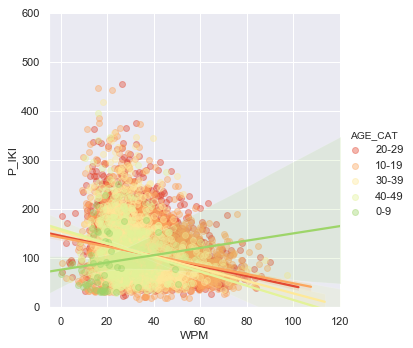

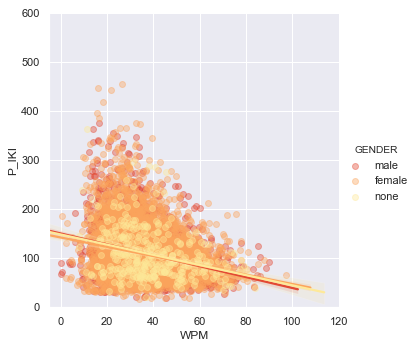

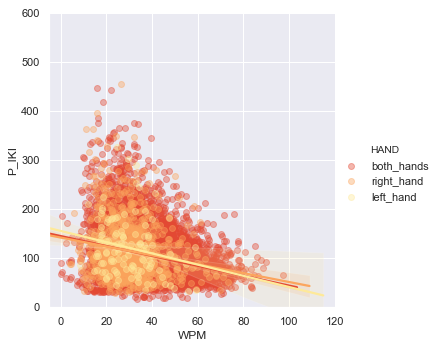

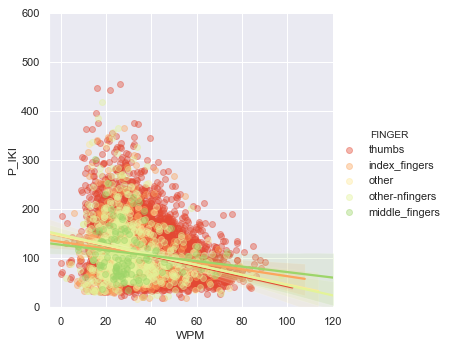

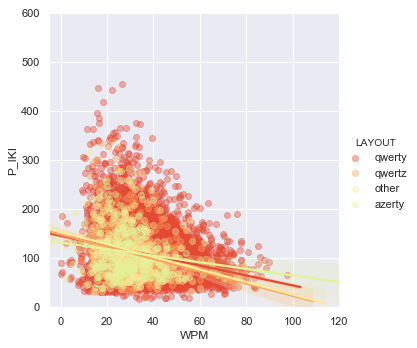

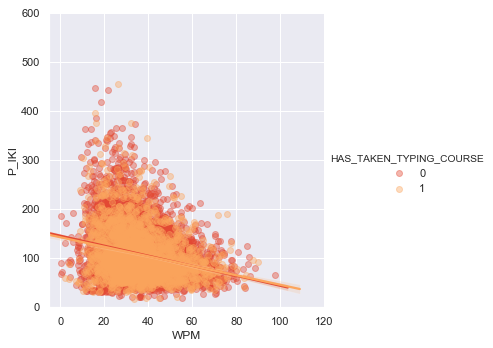

In [75]:
sns.set_palette('RdYlGn')
latents = ['AGE_CAT', 'GENDER', 'HAND', 'FINGER', 'LAYOUT', 'HAS_TAKEN_TYPING_COURSE']

for i in range(0,len(latents)): 
    f = latents[i]
    g = sns.lmplot(x="WPM", y="P_IKI", data = participants, hue=f, scatter_kws={'alpha': 0.4})
    g = g.set(xlim=(-5, 120), ylim=(-1, 600))

#### WPM vs ERROR_RATE

In [16]:
#ROWS = 1
#COLS = 1
#fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(5,5), sharey=True)
#subset = (participants.WPM > 20) &  (participants.WPM < 80) & (participants.ERROR_RATE >= 0) &  (participants.ERROR_RATE < 4) 
#sns.jointplot(x='WPM', y='ERROR_RATE', data=participants[subset], kind="kde")

#sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips)
#sns.lmplot(x='WPM', y='ERROR_RATE', data=participants, scatter=False);


In [17]:
#sns.jointplot(x='AGE', y='WPM', data=participants, kind="kde")
#sns.lmplot(x='AGE', y='WPM', data=participants, scatter=False);

In [18]:

#sns.jointplot(x='AGE', y='ERROR_RATE', data=participants, kind="kde")
#sns.lmplot(x='AGE', y='ERROR_RATE', data=participants, scatter=False);

#### WPM vs typing startegy

In [119]:
participants['HAND_FINGER'] = participants['HAND']+';'+participants['FINGER'] 

In [120]:
participants.HAND_FINGER.value_counts()

both_hands;thumbs            6203
right_hand;thumbs             785
both_hands;other-nfingers     551
both_hands;index_fingers      267
right_hand;index_fingers      196
both_hands;other              100
left_hand;thumbs               89
right_hand;middle_fingers      60
both_hands;middle_fingers      58
right_hand;other               38
right_hand;other-nfingers      34
left_hand;index_fingers        14
left_hand;middle_fingers        7
left_hand;other-nfingers        6
left_hand;other                 5
Name: HAND_FINGER, dtype: int64

In [28]:
#sns.catplot(x="FINGERS", y="WPM", hue="GENDER", col="HAND", aspect=.6, kind="swarm", data=participants);

In [29]:
sns.set_palette('RdYlGn')

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
sns.boxplot(x="ERROR_RATE", y="WPM", hue="GENDER", data=participants, ax=axs);
axs.set_xticklabels(axs[0].get_xticklabels(),rotation=80)


[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

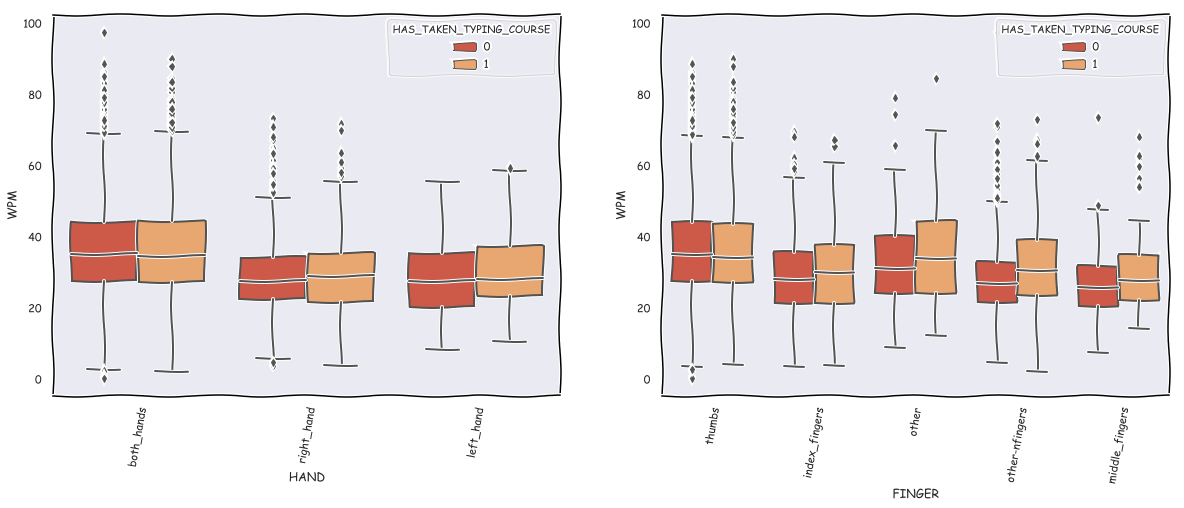

In [100]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="HAS_TAKEN_TYPING_COURSE", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="HAS_TAKEN_TYPING_COURSE", data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

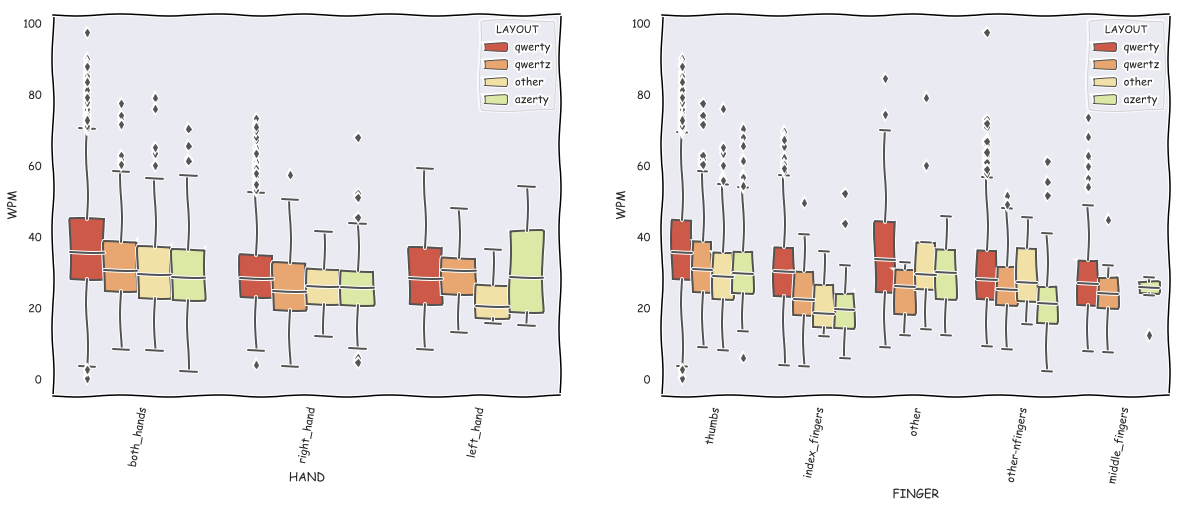

In [101]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="LAYOUT", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="LAYOUT", data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'thumbs'),
 Text(0,0,'index_fingers'),
 Text(0,0,'other'),
 Text(0,0,'other-nfingers'),
 Text(0,0,'middle_fingers')]

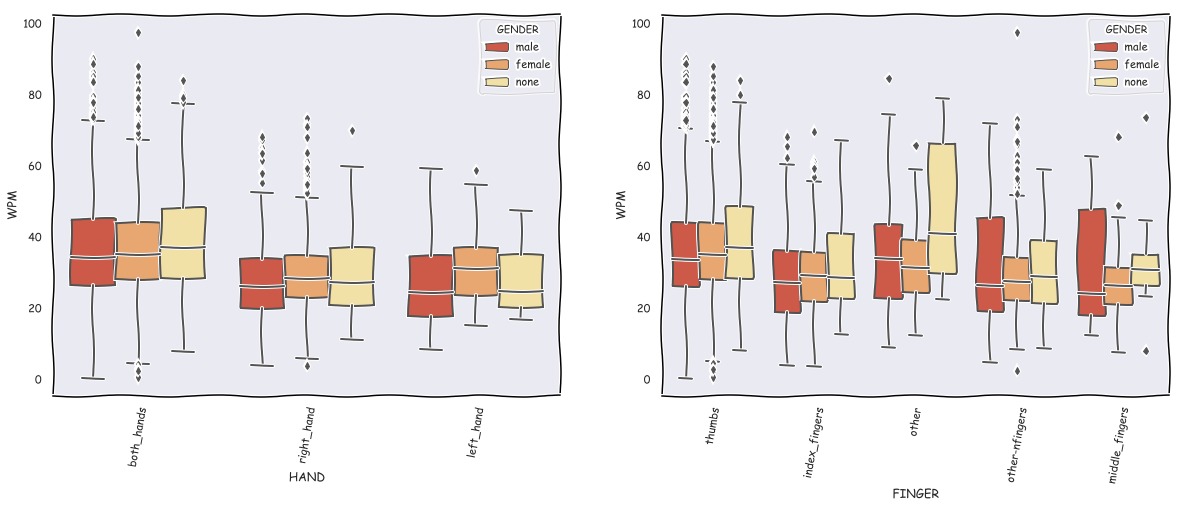

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="HAND", y="WPM", hue="GENDER", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="FINGER", y="WPM", hue="GENDER",  data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)

[Text(0,0,'Facebook'),
 Text(0,0,'Chrome Mobile WebView'),
 Text(0,0,'Chrome'),
 Text(0,0,'Chrome Mobile'),
 Text(0,0,'Mobile Safari'),
 Text(0,0,'Samsung Internet'),
 Text(0,0,'Mobile Safari UI/WKWebView'),
 Text(0,0,'Chrome Mobile iOS'),
 Text(0,0,'Crosswalk'),
 Text(0,0,'UC Browser'),
 Text(0,0,'Amazon Silk'),
 Text(0,0,'Firefox Mobile'),
 Text(0,0,'Pinterest'),
 Text(0,0,'Opera Mobile'),
 Text(0,0,'Edge Mobile'),
 Text(0,0,'Android'),
 Text(0,0,'Firefox iOS')]

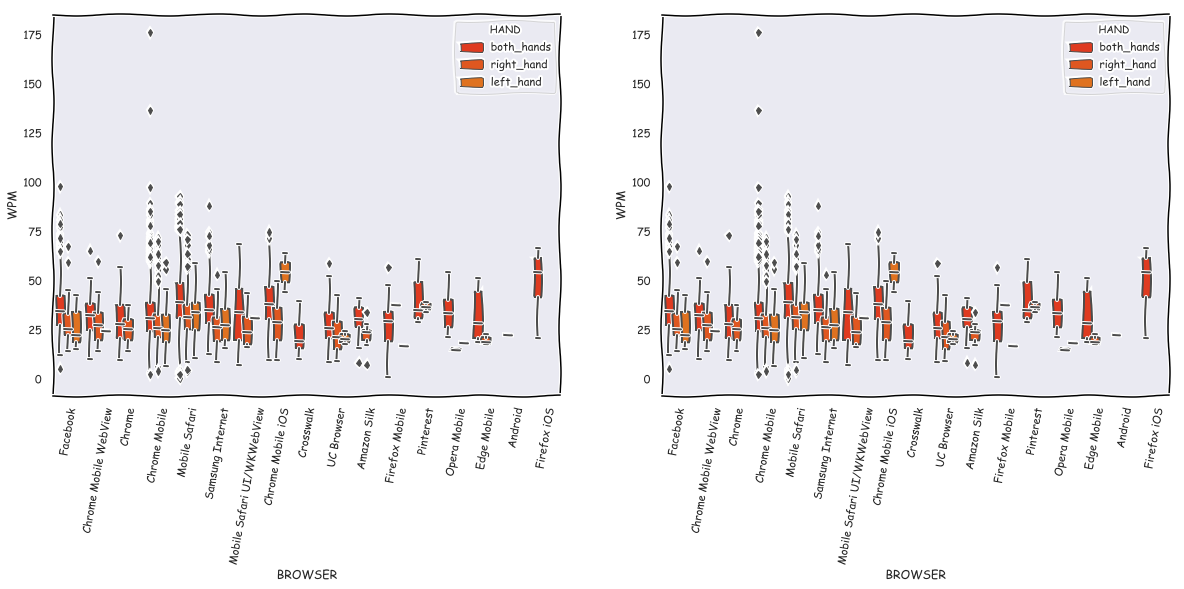

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.boxplot(x="BROWSER", y="WPM", hue="HAND", data=participants, ax=axs[0]);
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=80)

sns.boxplot(x="BROWSER", y="WPM", hue="HAND",  data=participants, ax=axs[1]);
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation=80)